In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import json
from PIL import Image
import cv2
# import albumentations
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss

In [10]:
import numpy as np
import torch
import pandas as pd
import random
import string

In [11]:
model_name = 'efficientnet-b2'

In [12]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained(model_name) 

Loaded pretrained weights for efficientnet-b2


In [13]:
np.random.seed(42)

In [14]:
image_size = EfficientNet.get_image_size(model_name)

In [17]:
# def check_dataset_images(data_dir):
#     """
#     Some images in the dataset are corrupted or do not have any data, this method removes them
#     """
#     for i in os.listdir(data_dir):
#         for j in os.listdir(os.path.join(data_dir, i)):
#             try:
#                 img = Image.open(os.path.join(os.path.join(data_dir, i), j)) # open the image file
#                 img.verify() # verify that it is, in fact an image
#             except (IOError, SyntaxError) as e:
#                 print(j,"not real image - removing")
#                 if os.path.exists(os.path.join(os.path.join(data_dir, i), j)):
#                     os.remove(os.path.join(os.path.join(data_dir, i), j))

In [18]:
# data_dir = '../../data/train/'
# check_dataset_images(data_dir)

In [19]:
src = (ImageList.from_folder(path=data_dir).split_by_rand_pct(0.2).label_from_folder())

In [20]:
res = []
res.append(rotate(degrees=(-90,90), p=1))

In [21]:
tfms=(res,[])

In [22]:
data = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH).databunch(bs=32).normalize(imagenet_stats))

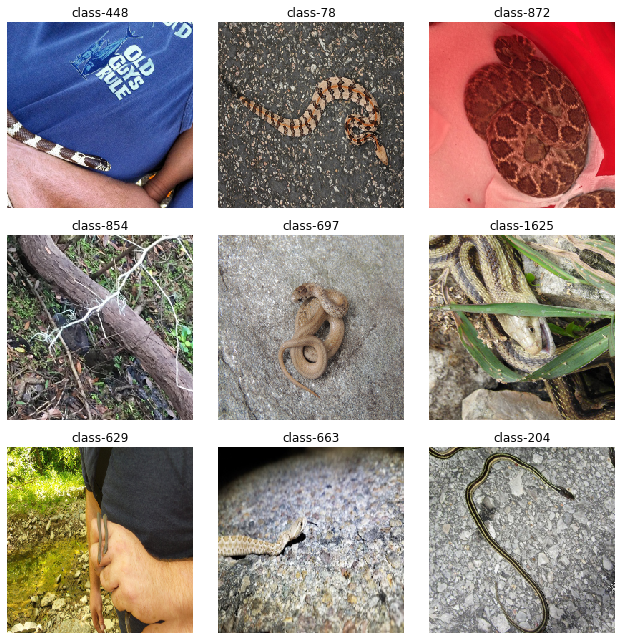

In [23]:
data.show_batch(3,figsize=(9,9))

In [24]:
list(children(model))[-2:]

[Linear(in_features=1408, out_features=1000, bias=True),
 MemoryEfficientSwish()]

In [25]:
model.add_module('_fc',nn.Linear(1408, data.c))

In [26]:
loss_func = LabelSmoothingCrossEntropy()

In [27]:
RMSprop = partial(torch.optim.RMSprop)

In [28]:
from torch.optim import Optimizer

In [29]:
learn = Learner(data, model, loss_func=loss_func, opt_func=RMSprop, metrics=[accuracy,FBeta(beta=1,average='macro')]).to_fp16()

In [30]:
learn.split([[learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:8]],
             [learn.model._blocks[8:],learn.model._conv_head], 
             [learn.model._bn1,learn.model._fc]])
print("pls")

pls


In [31]:
lr=1e-3

In [32]:
learn.fit_one_cycle(40,max_lr=slice(lr/100,lr), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.972425,1.806589,0.617485,0.529233,38:27
1,1.849413,1.701363,0.648183,0.582913,29:38
2,1.774343,1.712461,0.657829,0.580865,23:17
3,1.769043,1.689329,0.656495,0.603743,21:46
4,1.731970,1.661902,0.665291,0.601849,21:12
5,1.664041,1.658345,0.672996,0.605785,20:16
6,1.629070,1.663150,0.666141,0.610275,20:20
7,1.601588,1.633876,0.680095,0.614289,20:16
8,1.563584,1.641809,0.686101,0.625993,20:17
9,1.531227,1.733078,0.647819,0.590327,20:23


Better model found at epoch 0 with accuracy value: 0.6174846887588501.
Better model found at epoch 1 with accuracy value: 0.6481829881668091.
Better model found at epoch 2 with accuracy value: 0.6578292846679688.
Better model found at epoch 4 with accuracy value: 0.6652914881706238.
Better model found at epoch 5 with accuracy value: 0.6729964017868042.
Better model found at epoch 7 with accuracy value: 0.6800946593284607.
Better model found at epoch 8 with accuracy value: 0.6861008405685425.
Better model found at epoch 10 with accuracy value: 0.7053934335708618.
Better model found at epoch 11 with accuracy value: 0.7164351344108582.
Better model found at epoch 14 with accuracy value: 0.7233513593673706.
Better model found at epoch 15 with accuracy value: 0.7272948026657104.
Better model found at epoch 16 with accuracy value: 0.731662929058075.
Better model found at epoch 20 with accuracy value: 0.7414912581443787.
Better model found at epoch 23 with accuracy value: 0.7446460127830505.


In [33]:
save_name = model_name+"_trained_for_40"
learn.save(save_name, return_path=True)

PosixPath('../../data/train/models/efficientnet-b2_trained_for_40.pth')